# Tutorial showing the integration between the QDAC2 and the OPX to perform voltage sweeps using the pyvisa commands

In this tutorial you will learn how to combine the QDAC2 with the OPX to perform n-dimensional voltage scans efficiently.

The trick here is to use a digital marker from the OPX to trigger the QDAC and make it step the output voltage of a given channel across a pre-loaded voltage list. Please note that the size of this list is limited to 65536 items per channel.

In this case, the latency induced by the communication between the control PC and the instruments and by transferring the data is suppressed since everything is controlled by the OPX pulse processor. The experimental runtime is then given by the QDAC bandwidth and the integration time. 

In [24]:
import pyvisa as visa
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from configuration import *
import numpy as np
import matplotlib.pyplot as plt
from time import time
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import wait_until_job_is_paused

## Helper functions

A class called **QDACII** is created to enable the communication with the QDAC. 
It can also be modified to create your own driver.

A function is also defined in order to easily program the QDAC2 to load a voltage list and step trhough it on the event of an external trigger (provided by the OPX here). Sevral parameters such as the filter, dynamic range and dwell time can be set.

In [2]:
# QDAC2 instrument class
class QDACII():
    def __init__(self, communication_type:str, IP_address:str = None, port:int = 5025, USB_device:int = None, lib:str = '@py'):
        """
        Open the communication to a QDAC2 instrument with python. The communication can be enabled via either Ethernet or USB.

        :param communication_type: Can be either "Ethernet" or "USB".
        :param IP_address: IP address of the instrument - required only for Ethernet communication.
        :param port: port of the instrument, 5025 by default - required only for Ethernet communication.
        :param USB_device: identification number of the device - required only for USB communication.
        :param lib: use '@py' to use pyvisa-py backend (default).
        """
        rm = visa.ResourceManager(lib)  # To use pyvisa-py backend, use argument '@py'
        if communication_type == "Ethernet":
            self._visa = rm.open_resource(f"TCPIP::{IP_address}::{port}::SOCKET")
            self._visa.baud_rate = 921600
            # self._visa.send_end = False
        elif communication_type == "USB":
            self._visa = rm.open_resource(f"ASRL{USB_device}::INSTR")

        self._visa.write_termination = '\n'
        self._visa.read_termination = '\n'
        print(self._visa.query("*IDN?"))
        print(self._visa.query("syst:err:all?"))

    def query(self, cmd):
        return self._visa.query(cmd)

    def write(self, cmd):
        self._visa.write(cmd)

    def write_binary_values(self, cmd, values):
        self._visa.write_binary_values(cmd, values)

    def __exit__(self):
        self.close()

# load list of voltages to the relevant QDAC2 channel
def load_voltage_list(qdac, channel:int, dwell:float, trigger_port:str, output_range:str, output_filter:str, voltage_list:list):
    """
    Configure a QDAC2 channel to play a set of voltages from a given list and step through it according to an external trigger given by an OPX digital marker, using pyvisa commands.

    :param qdac: the QDAC2 object.
    :param channel: the QDAC2 channel that will output the voltage from the voltage list.
    :param dwell: dwell time at each voltage level in seconds - must be smaller than the trigger spacing and larger than 2e-6.
    :param trigger_port: external trigger port to which a digital marker from the OPX is connected - must be in ["ext1", "ext2", "ext3", "ext4"].
    :param output_range: the channel output range that can be either "low" (+/-2V) or "high" (+/-10V).
    :param output_filter: the channel output filter that can be either "dc" (10Hz), "med" (10kHz) or "high" (300kHZ).
    :param voltage_list: list containing the desired voltages to output - the size of the list must not exceed 65536 items.
    :return:
    """
    # Load the list of voltages
    qdac.write_binary_values(f"sour{channel}:dc:list:volt ", voltage_list)
    # Ensure that the output voltage will start from the beginning of the list.
    qdac.write(f"sour{channel}:dc:init:cont off")
    # Set the minimum time spent on each voltage level. Must be between 2µs and the time between two trigger events.
    qdac.write(f"sour{channel}:dc:list:dwell {dwell}")
    # Step through the voltage list on the event of a trigger
    qdac.write(f"sour{channel}:dc:list:tmode stepped")
    # Set the external trigger port. Must be in ["ext1", "ext2", "ext3", "ext4"]
    qdac.write(f"sour{channel}:dc:trig:sour {trigger_port}")
    # Listen continuously to trigger
    qdac.write(f"sour{channel}:dc:init:cont on")
    # Make sure that the correct DC mode (LIST) is set, as opposed to FIXed.
    qdac.write(f"sour{channel}:dc:mode LIST")
    # Set the channel output range
    qdac.write(f"sour{channel}:rang {output_range}")
    # Set the channel output filter
    qdac.write(f"sour{channel}:filt {output_filter}")
    print(f"Set-up QDAC2 channel {channel} to step voltages from a list of {len(voltage_list)} items on trigger events from the {trigger_port} port with a {qdac.query(f'sour{channel}:dc:list:dwell?')} s dwell time.")


## Connect to the instruments

In [3]:
# Create the qdac instrument
qdac = QDACII("Ethernet", IP_address="172.16.33.100", port=5025)  # Using Ethernet protocol
# qdac = QDACII("USB", USB_device=4)  # Using USB protocol

QDevil, QDAC-II, 2, 11-1.14
0, "No error"


In [19]:
# Open a Quantum Machine Manager
qmm = QuantumMachinesManager(host="172.16.33.100", cluster_name="Cluster_83")

2023-09-26 13:28:20,702 - qm - INFO     - Performing health check
2023-09-26 13:28:20,881 - qm - INFO     - Health check passed


## Example experiments:
1. 1D voltage sweep performed by the QDAC while the OPX is measuring using do1d
2. 1D voltage sweep performed by the QDAC which is triggered by the OPX which is also measuring using do0d
3. 2D voltage sweep where the fast axis is performed by the OPX while the slow axis is handled by the QDAC using do1d

### Experiment 1: 1D voltage sweep performed by the QDAC while the OPX is measuring (slow method)
In this example, the QDAC is parametrized to output a constant voltage which is swept outside of QUA using a python loop. Here the OPX is simply measuring at each level, but the QUA program can easily be modified to complexify the sequence.

This method is similar to how any external DC voltage source would be integrated with the OPX without triggering.

In [31]:
%matplotlib qt
n_avg = 100  # Number of averaging loops

### OPX section
with program() as prog:
    i = declare(int)
    n = declare(int)
    data = declare(fixed)
    data_st = declare_stream()
    with for_(i, 0, i < len(voltage_values), i + 1):
        pause()
        with for_(n, 0, n < n_avg, n + 1):
            # Wait 1ms before measuring (depends of the QDAC filter option)
            wait(1_000_000 // 4, "readout_element")
            # Measure for 10µs with the OPX - Can be replaced by dual_demod, demod or else
            measure("readout", "readout_element", None, integration.full("const", data, "out1"))
            # Send the result to the stream processing
            save(data, data_st)

    with stream_processing():
        # Average all the data and save the values into "data".
        data_st.buffer(n_avg).map(FUNCTIONS.average()).save_all("data")

# Open a quantum machine
qm = qmm.open_qm(config)

### QDAC2 section
qdac_channel = 1
qdac.write("*rst")  # Reset the qdac parameters to start from a blank instrument
# Set the current range ("high" or "low") and filter ("dc": 10Hz ,  "med": 10khz,  "high": 300kHz)
# Set the channel output range
qdac.write(f"sour{qdac_channel}:rang low")
# Set the channel output filter
qdac.write(f"sour{qdac_channel}:filt med")
qdac.write(f'sour{qdac_channel}:volt:mode fix')

### Run the experiment
start_time = time()
job = qm.execute(prog)
# Live plotting
fig = plt.figure()
interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
data_handle = job.result_handles.get("data")
data_tot = []
for i, vg in enumerate(voltage_values1):
    # Update the QDAC level
    qdac.write(f'sour{qdac_channel}:volt {vg}')
    
    # Resume the QUA program (escape the 'pause' statement)
    job.resume()
    # Wait until the program reaches the 'pause' statement again, indicating that the QUA program is done
    wait_until_job_is_paused(job)
    # Wait until the data of this run is processed by the stream processing
    data_handle.wait_for_values(i + 1)
    # Fetch the data from the last OPX run corresponding to the current LO frequency
    data = data_handle.fetch(i)["value"] * 2**12 / readout_len
    # Update the list of global results
    data_tot.append(data)
    # Plot results
    plt.cla()
    plt.plot(voltage_values[:i], data_tot[:i])
    plt.xlabel("QDAC level [V]")
    plt.ylabel("Data [V]")
    plt.pause(0.1)

print(f"Elapsed time: {time() - start_time:.2f} s")
# Interrupt the FPGA program
job.halt()
qdac.write(f'sour{qdac_channel}:volt {0}')

2023-09-26 13:33:14,989 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 
2023-09-26 13:33:14,990 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1695727957563 is canceling running job 1695403904990.
2023-09-26 13:33:15,378 - qm - INFO     - Sending program to QOP for compilation
2023-09-26 13:33:15,774 - qm - INFO     - Executing program
Elapsed time: 112.06 s


True

In [22]:
vg

-1.5

### Experiment 2: 1D voltage sweep performed by the QDAC which is triggered by the OPX which is also measuring

In this example, the QDAC is parametrized to output the values defined in a pre-loaded voltage list. Stepping to the next value is done on the event of a digital marker sent by the OPX to one of the QDAC external trigger input. 
Here the OPX is simply triggering the QDAC and measuring at each level, but the QUA program can easily be modified to complexify the sequence.

This method is very similar to the previous one but significantly reduces the runtime since it avoids the communication time.

Set-up QDAC2 channel 1 to step voltages from a list of 101 items on trigger events from the ext3 port with a 2e-06 s dwell time.
2023-09-26 13:25:39,901 - qm - INFO     - Sending program to QOP for compilation
2023-09-26 13:25:40,322 - qm - INFO     - Executing program
Elapsed time: 11.52 s


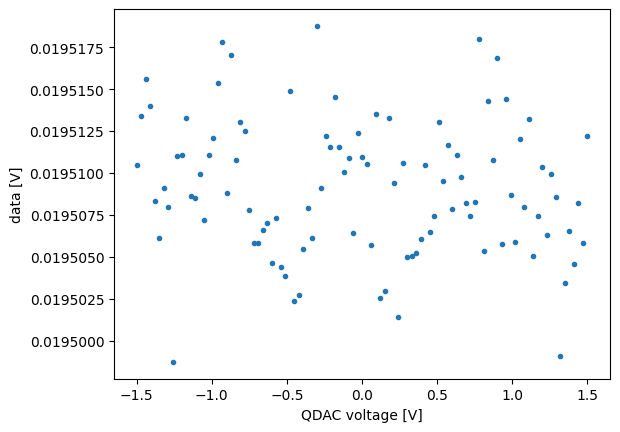

In [10]:
n_avg = 100  # Number of averaging loops
# Voltage values in Volt
voltage_values1 = list(np.linspace(-1.5, 1.5, 101))

### OPX section
with program() as qdac_1d_sweep:
    i = declare(int)
    n = declare(int)
    data = declare(fixed)
    data_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(i, 0, i < len(voltage_values1), i + 1):
            # Wait 1ms before measuring (depends of the QDAC filter option)
            wait(1_000_000 // 4, "qdac_trigger1", "readout_element")
            # Trigger the QDAC channel to output the next voltage level from the list
            play("trig", "qdac_trigger1")
            # Measure with the OPX
            measure("readout", "readout_element", None, integration.full("const", data, "out1"))
            # Send the result to the stream processing
            save(data, data_st)

    with stream_processing():
        # Average all the data and save the values into "data".
        data_st.buffer(len(voltage_values1)).buffer(n_avg).map(FUNCTIONS.average()).save("data")

# Open a quantum machine
qm = qmm.open_qm(config)
            
### QDAC2 section
qdac.write("*rst")  # Reset the qdac parameters to start from a blank instrument
# Set up the qdac and load the voltage list
load_voltage_list(qdac, channel=1, dwell=2e-6, trigger_port="ext3", output_range="low", output_filter="med", voltage_list=voltage_values)

start_time = time()

# Execute the sequence
job = qm.execute(qdac_1d_sweep)
# Fetch the data at the end of the program
job.result_handles.wait_for_all_values()
data = job.result_handles.get("data").fetch_all()
# Process and plot the data
plt.figure()
data = data * readout_len / 2**12
plt.plot(voltage_values1, data, ".")
plt.xlabel("QDAC voltage [V]")
plt.ylabel("data [V]")

print(f"Elapsed time: {time() - start_time:.2f} s")

### Experiment 3: 2D voltage sweep where the fast axis is performed by the OPX while the slow axis is handled by the QDAC using do1d

In this example, the QDAC is parametrized to output a constant voltage on one channel, that will serve as an offset added to the voltage scan performed by the OPX, and output another constant voltage on a second channel which will be scanned using the do1d qcodes method.

The idea is to acquire a charge stability map using a raster scan (for finding quantum dots), where the fast axis is swept using one analog output of the OPX, while the slow axis is handled by the QDAC and do1d.

The scan performed by the OPX is handled using a sticky element (https://docs.quantum-machines.co/0.1/qm-qua-sdk/docs/Guides/features/?h=hold_off#sticky-element) which allows to output a continuous staircase-like pattern.

This method is an extention of the previous ones showing how to sweep two voltage axes.

In [ ]:
n_avg = 100  # Number of averaging loops

# Voltage values in Volt
voltage_values1 = np.linspace(-0.4, 0.4, 101)
voltage_values2 = list(np.linspace(-2.5, 2.5, 101))
qdac_offset = 3.752  # Offset to add to the axis scanned by the OPX in V

### QDAC2 section
qdac2.reset()  # Reset the qdac parameters
# Channel 1
ch1 = qdac2.channel(1)
ch1.output_mode(range="high", filter="dc")
Vg1 = ch1.dc_constant_V(qdac_offset)  # Set an offset that will be combined with the OPX fast scan (3.752 +/- 0.3V)
# Channel 2
ch2 = qdac2.channel(2)
ch2.output_mode(range="low", filter="med")
Vg2 = ch2.dc_constant_V  # Define the voltage parameter for this channel

### OPX section
start = voltage_values1[0] / step_amp
step = np.mean(np.diff(voltage_values1)) / step_amp

def qdac_opx_combined(simulate=False):
    with program() as prog:
        i = declare(int)
        n = declare(int)
        data = declare(fixed)
        data_st = declare_stream()

        with infinite_loop_():
            if not simulate:
                pause()
            play("step" * amp(start), "gate")
            # Wait 1ms before sweeping the fast axis (depends of the QDAC filter option)
            wait(1_000_000 // 4, "gate", "readout_element")
            with for_(i, 0, i < len(voltage_values1), i + 1):
                # Step the voltage along the fast axis except for the first point
                with if_(i > 0):
                    play("step" * amp(step), "gate")
                # Wait before measuring
                wait(10_000 // 4, "readout_element")
                with for_(n, 0, n < n_avg, n + 1):
                    # Measure with the OPX
                    measure("readout", "readout_element", None, integration.full("const", data, "out1"))
                    # Send the result to the stream processing
                    save(data, data_st)
            # Bring the voltage back to zero
            ramp_to_zero("gate")

        with stream_processing():
            # Average all the data and save the values into "data".
            data_st.buffer(n_avg).map(FUNCTIONS.average()).buffer(len(voltage_values1)).save_all("data")
    return prog

# Pass the readout length (in ns) to the class to convert the demodulated/integrated data into Volts
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = qdac_opx_combined(simulate=False)
# Axis1 is the most inner non-averaging loop
opx_instrument.set_sweep_parameters("axis1", voltage_values1 + qdac_offset, "V", "Vg1")

### Run the experiment
experiment3 = load_or_create_experiment("Combined_2D_sweep_do1d", sample_name)

start_time = time()
do1d(
    Vg2, voltage_values2[0], voltage_values2[-1], len(voltage_values2), 0.001,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(),
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    # do_plot=True,
    exp=experiment3,
)
print(f"Elapsed time: {time() - start_time:.2f} s")